In [1]:
# Import Libraries
# =========

import re
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU, Embedding, Input, Bidirectional
from keras.layers.pooling import GlobalAveragePooling1D
from keras.initializers import Constant
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC

import nltk
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

import tqdm
from tqdm import tqdm

In [2]:
# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)
# To plot pretty figures

In [3]:
# Reading csv data files using pandas dataframe 
# =============

train = pd.read_csv("../data/nlp/train.csv.zip", encoding = "ISO-8859-1")
test = pd.read_csv("../data/nlp/test.csv.zip", encoding = "ISO-8859-1")

In [4]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [5]:
test.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [6]:
### Before cleaning the dataset I would like to perform EDA(Exploratory data analysis) by performing data visualization to understand
### the distribution of different classes. I will be performing EDA on training dataset

categorywise_data = train.drop(['id', 'comment_text'], axis=1)     ### Removed unnecessary columns - id and comment_text
counts_category = []                                               ### A list that contains tuple which consists of class label and number of comments for that particular class 
categories = list(categorywise_data.columns.values)
for i in categories:
    counts_category.append((i, categorywise_data[i].sum()))
    
dataframe = pd.DataFrame(counts_category, columns=['Labels', 'number_of_comments'])   ### Dataframe made up of category and total number of comments

Text(0.5, 0, 'Labels')

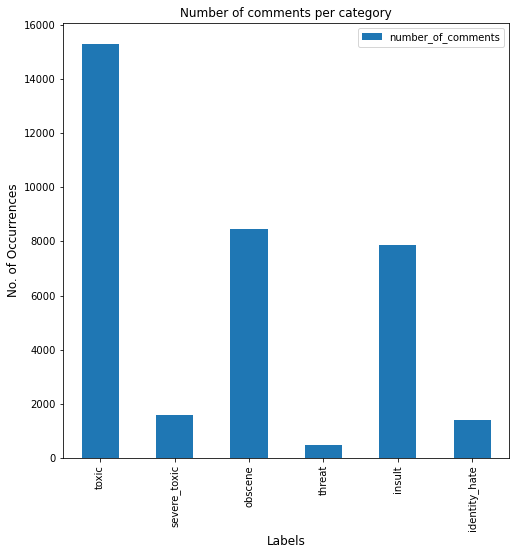

In [7]:
### Visualization 1

### Bar graph of total number of comments per label 
### This visualization is helpful in identifying the total number of comments per label
dataframe.plot(x='Labels', y='number_of_comments', kind='bar',figsize=(8,8))
plt.title("Number of comments per category")
plt.ylabel('No. of Occurrences', fontsize=12)
plt.xlabel('Labels', fontsize=12)

### From the below graph we can observe that most of the comments having toxic label. 
### Threat label is having lowest no. of comments

In [8]:
# Remove the Stop world
# Convert everything to lower case
# Remove special characters and punctuations
# Remove wordds that have lwss than 3 charecters
# =============

stemmer = nltk.SnowballStemmer("english")
stop_words = set(stopwords.words('english'))
def preprocess(string):
    string = string.lower() # Convert everything to lower case.
    string = re.sub('[^A-Za-z0-9]+', ' ', string) # Remove special characters and punctuations
    string = re.sub(r'\b\w{1,3}\b', ' ', string) # Remove words that have less than 3 characters
    
    x = string.split()
    new_text = []
    
    for word in x:
        if word not in stop_words: # Remove stop worlds
            new_text.append(stemmer.stem(word))
            
    string = ' '.join(new_text)
    return string

In [9]:
%%time
train['preprocessed_text'] = train['comment_text'].apply(preprocess) # Compute the train prepossing time

CPU times: user 1min 46s, sys: 1.38 s, total: 1min 48s
Wall time: 1min 53s


In [10]:
%%time
test['preprocessed_text'] = test['comment_text'].apply(preprocess) # Compute the test prepossing time

CPU times: user 1min 34s, sys: 1.48 s, total: 1min 36s
Wall time: 1min 39s


In [11]:
# train test split
# ================

train_data = train[['preprocessed_text']]
train_label = train[['toxic', 'severe_toxic', 'obscene', 'threat','insult', 'identity_hate']]
test_data = test[['preprocessed_text']]
#X_train, X_validation, y_train, y_validation = train_test_split(train_full, train_label, shuffle = True, random_state = 123)

In [12]:
# Saving the files to csv so that we dont need to preprocess again.
# =====================

train_data.to_pickle('train_data.pkl')
test_data.to_pickle('test_data.pkl')

In [13]:
# To load the csv files:
# =============

train_data = pd.read_pickle('train_data.pkl')
test_data = pd.read_pickle('test_data.pkl')

In [14]:
def load_glove():
    embedding_dict = {}
    path = '../data/glove.6B/glove.6B.100d.txt'
    with open(path, 'r') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vectors = np.asarray(values[1:], 'float32')
            embedding_dict[word] = vectors
    f.close()

    return embedding_dict


#embeddings_index = load_glove()
#embeddings_index['london'].shape

In [15]:
train_data.head()

,preprocessed_text
0,explan edit made usernam hardcor metallica rev...
1,match background colour seem stuck thank talk ...
2,realli tri edit constant remov relev inform ta...
3,make real suggest improv wonder section statis...
4,hero chanc rememb page


In [16]:
MAX_LEN=150

train_text = train_data["preprocessed_text"]
test_text = test_data["preprocessed_text"]

### Creating corpus of words and coverting it into integer and then susbstituing it in sentences - prepare tokenizer

tokenizer=Tokenizer(num_words = 40000) # Tokenizer(num_words = 50000) #50000 words are used here
tokenizer.fit_on_texts(train_text)

#convert each text into array of integers with help of tokenizer.
train_seq=tokenizer.texts_to_sequences(train_text)
test_seq=tokenizer.texts_to_sequences(test_text)


### Padding - Every sentence is unequal in length. We need to have all the sentence equal in lengths
### If length of sentence is less than 150 then padding will increase sentence length to 150 by adding zeros, if its greater
### than 150 then it will reduce the length of sentence to 150 by trimming the words

train_padded =pad_sequences(train_seq, maxlen=MAX_LEN)
test_padded =pad_sequences(test_seq, maxlen=MAX_LEN)
print("Shape of training data",train_padded.shape)
print("Shape of testing data",test_padded.shape)


Shape of training data (159571, 150)
Shape of testing data (153164, 150)


In [17]:
word_index=tokenizer.word_index
num_words = len(word_index)
print('Number of unique words:',len(word_index))

Number of unique words: 137691


In [18]:
def prepare_matrix(embedding_dict, emb_size=100):
    num_words = len(word_index)
    embedding_matrix = np.zeros((num_words, emb_size))

    for word, i in tqdm(word_index.items()):
        if i > num_words:
            continue

    emb_vec = embedding_dict.get(word)
    if emb_vec is not None:
        embedding_matrix[i] = emb_vec

    return embedding_matrix

In [30]:
def model1(embedding_matrix):
    
    embedding=Embedding(num_words,embedding_matrix.shape[1], weights=[embedding_matrix],
                   input_length=MAX_LEN,trainable=False)
    
    model = Sequential()
    model.add(embedding)
    model.add(LSTM(units = 64, dropout = 0.2,return_sequences=True))
    model.add(LSTM(units = 64, dropout = 0.2))
    model.add(Dense(units = 6, activation = 'sigmoid'))
    
    optimzer=Adam(learning_rate=1e-5)

    model.compile(loss='binary_crossentropy',optimizer=optimzer,metrics=['AUC'])
    
    return model


In [31]:
def model2(embedding_matrix):
    
    embedding=Embedding(num_words,embedding_matrix.shape[1], weights=[embedding_matrix],
                   input_length=MAX_LEN,trainable=False)
    
    model = Sequential()
    model.add(embedding)
    model.add(GRU(units = 64, dropout = 0.2,return_sequences=True))
    model.add(GRU(units = 64, dropout = 0.2))
    model.add(Dense(units = 6, activation = 'sigmoid'))
    
    optimzer=Adam(learning_rate=1e-5)

    model.compile(loss='binary_crossentropy',optimizer=optimzer,metrics=['AUC'])
    
    return model

In [32]:
X_train, X_validation, y_train, y_validation = train_test_split(train_padded, train_label, shuffle = True, random_state = 123)

In [33]:
embeddings_index=load_glove()
embedding_matrix=prepare_matrix(embeddings_index)

100%|██████████| 137691/137691 [00:00<00:00, 1992031.82it/s]


In [34]:
model1=model1(embedding_matrix)
model1.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 150, 100)          13769100  
_________________________________________________________________
lstm_4 (LSTM)                (None, 150, 64)           42240     
_________________________________________________________________
lstm_5 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 390       
Total params: 13,844,754
Trainable params: 75,654
Non-trainable params: 13,769,100
_________________________________________________________________


In [35]:
model2=model2(embedding_matrix)
model2.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 150, 100)          13769100  
_________________________________________________________________
gru_4 (GRU)                  (None, 150, 64)           31872     
_________________________________________________________________
gru_5 (GRU)                  (None, 64)                24960     
_________________________________________________________________
dense_5 (Dense)              (None, 6)                 390       
Total params: 13,826,322
Trainable params: 57,222
Non-trainable params: 13,769,100
_________________________________________________________________


In [36]:
history=model1.fit(X_train,y_train,
                  batch_size=1000,
                  epochs=1,
                  validation_data=(X_validation,y_validation),
                  verbose=2)

120/120 - 268s - loss: 0.6906 - auc: 0.5652 - val_loss: 0.6873 - val_auc: 0.7075


In [38]:
history=model2.fit(X_train,y_train,
                  batch_size=1000,
                  epochs=3,
                  validation_data=(X_validation,y_validation),
                  verbose=2)

Epoch 1/3
120/120 - 230s - loss: 0.6802 - auc: 0.5506 - val_loss: 0.6737 - val_auc: 0.6059
Epoch 2/3
120/120 - 224s - loss: 0.6650 - auc: 0.5750 - val_loss: 0.6544 - val_auc: 0.6059
Epoch 3/3
120/120 - 222s - loss: 0.6397 - auc: 0.5861 - val_loss: 0.6215 - val_auc: 0.6059
